# Import

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from _datetime import datetime

import warnings; warnings.simplefilter('ignore')

# Read csv

In [2]:
weather_data = pd.read_csv('./data/weatherstats_edmonton_hourly.csv')
mos_data = pd.read_csv('./data/Mosquito_Trap_Data.csv')

# mos data

In [3]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list


mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] > start_remove) & (mos_data["Trap Date"] < end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] > mos_date_start) & (mos_data['Trap Date'] < mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')


mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


,Count
Trap Date,
2018-06-12,9938


In [4]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
19195,2017-05-16,Ochlerotatus,Black legs,Female,UnID,13,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
6338,2017-05-16,Ochlerotatus,Black legs,Female,UnID,1,Outer Community-South1,NaN,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
888,2017-05-16,Culiseta,alaskaensis,Female,NaN,1,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
26275,2017-05-16,Male,UnID,Male,UnID,1,River Valley-East-P1,NaN,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
18595,2017-05-16,Culiseta,inornata,Female,NaN,1,Rural-North West,NaN,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)


In [5]:
mos_count.head()

,Count
Trap Date,
2017-05-16,29
2017-05-23,523
2017-05-30,363
2017-06-06,1656
2017-06-13,2969


# weather data

In [6]:
start_date1 = '2017-05-10'
end_date1 = '2017-09-26'
start_date2 = '2018-05-09'
end_date2 = '2018-09-18'

##############Drop MST###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list


weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')


weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

In [7]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,relative_humidity,dew_point,temperature,health_index
14105,2017-05-10,1494396000,93.58,101.5,ESE,11.0,5.0,53.0,2.2,11.6,3.6
14082,2017-05-10,1494478800,93.54,101.4,ENE,7.0,6.0,58.0,4.4,12.6,3.3
14083,2017-05-10,1494475200,93.50,101.4,ENE,6.0,8.0,56.0,4.9,13.7,3.3
14084,2017-05-10,1494471600,93.47,101.3,NE,5.0,10.0,53.0,5.8,15.4,3.3
14085,2017-05-10,1494468000,93.43,101.3,ENE,6.0,11.0,46.0,5.4,17.2,3.2


# Classify gender

In [8]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]

mos_count_male = mos_data_male.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]


mos_count_female = mos_data_female.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')
#compare count

gender = np.array(mos_count_male['Gender'])

In [9]:
gender

array(['Female', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Female',
       'Female', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female', 'Female', 'Male', 'Female', 'Female', 'Male',
       'Male', 'Male', 'Male', 'Male', 'Male', 'Female', 'Female',
       'Female', 'Female', 'Female', 'Female', 'Male', 'Male', 'Male',
       'Male', 'Male', 'Male', 'Male'], dtype=object)

In [10]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

273


In [11]:
mos_data_grouped = mos_data.groupby(['Trap Date'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0]
})

merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')
merged_data.drop(columns=['date_time_local'], inplace=True)

In [12]:
merged_data.head()

,Trap Date,Count,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-16,29,Culiseta,Female,92.96,100.95,6.0,12.0,3.5,2.4,2.0
1,2017-05-23,523,Ochlerotatus,Female,92.37,100.60,20.0,13.0,5.1,27.6,2.8
2,2017-05-30,363,Ochlerotatus,Female,94.06,101.55,15.0,21.0,5.0,24.6,2.9
3,2017-06-06,1656,Ochlerotatus,Female,93.81,102.00,15.0,5.0,5.5,11.8,2.9
4,2017-06-13,2969,Ochlerotatus,Female,93.08,100.90,34.0,11.0,10.2,15.1,2.6


In [13]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]


mos_count_male = mos_data_male.groupby(["Trap Date"], as_index=False).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]



mos_count_female = mos_data_female.groupby(["Trap Date"], as_index=False).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')

In [14]:
t_list = []
for i in mos_count_male['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d 00:00:00")
    t2 = time.strftime("%Y-%m-%d 00:00:00", t1)
    t_list.append(t2)

mos_count_male['Trap Date'] = t_list

In [15]:
mos_count_male.head()

,Trap Date,Count,Count_female,Gender
0,2017-05-16 00:00:00,6,23,Female
1,2017-05-23 00:00:00,325,198,Male
2,2017-05-30 00:00:00,213,150,Male
3,2017-06-06 00:00:00,1130,526,Male
4,2017-06-13 00:00:00,1708,1261,Male


In [16]:
merged_data["Gender"] = mos_count_male["Gender"]
merged_data.drop(columns=['Count'], inplace=True)
merged_data

,Trap Date,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-16,Culiseta,Female,92.96,100.95,6.0,12.0,3.5,2.4,2.0
1,2017-05-23,Ochlerotatus,Male,92.37,100.60,20.0,13.0,5.1,27.6,2.8
2,2017-05-30,Ochlerotatus,Male,94.06,101.55,15.0,21.0,5.0,24.6,2.9
3,2017-06-06,Ochlerotatus,Male,93.81,102.00,15.0,5.0,5.5,11.8,2.9
4,2017-06-13,Ochlerotatus,Male,93.08,100.90,34.0,11.0,10.2,15.1,2.6
5,2017-06-20,Ochlerotatus,Male,93.12,100.90,16.0,17.0,10.0,11.0,2.4
6,2017-06-27,Ochlerotatus,Male,92.78,100.55,31.0,17.0,7.0,13.7,2.4
7,2017-07-04,Ochlerotatus,Female,93.84,101.50,20.0,7.0,6.6,22.7,2.4
8,2017-07-11,Ochlerotatus,Female,93.92,101.60,3.0,10.0,13.0,15.1,2.5
9,2017-07-18,Ochlerotatus,Female,93.95,101.65,20.0,10.0,7.5,9.7,1.8


# Logistic regression

In [17]:
cat = merged_data['Gender'].values
x1 = merged_data['dew_point'].values
x2 = merged_data['temperature'].values

In [18]:
cat1 = np.ones(len(cat)) #for pon-linear
for j in range(len(cat)):
    if cat[j]=='Male':
        cat1[j] = 0
    else:
        cat1[j] = 1
Labels = cat1.reshape(len(cat1),1)

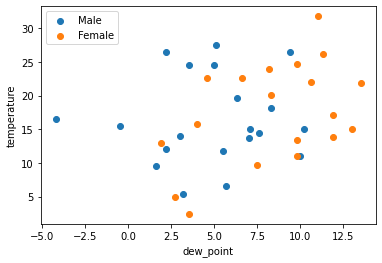

'\npressure_station  pressure sea 0.67\npressure_station  wind_dir_10s  0.67\npressure_station  wind_speed  0.67\npressure_station  dew_point  0.718\npressure_station  temperature  0.67\nhealth_index  0.67\n\npressure sea  wind_dir_10s  0.69\nwind_speed  0.64\ndew_point  0.718\ntemperature  0.615\nhealth_index  0.718\n\nwind_dir_10s  wind_speed  0.64\ndew_point  0.718\ntemperature  0.615\nhealth_index  0.69\n\nwind_speed  dew_point  0.69\ntemperature  0.67\nhealth_index  0.718\n\ndew_point  temperature  0.77\nhealth_index  0.69\n\ntemperature  health_index  0.718\n'

In [19]:
plt.scatter(x1[cat=='Male'],x2[cat=='Male'], label='Male')
plt.scatter(x1[cat=='Female'],x2[cat=='Female'], label='Female')
plt.xlabel('dew_point')
plt.ylabel('temperature')
plt.legend()
plt.show()

'''
pressure_station  pressure sea 0.67
pressure_station  wind_dir_10s  0.67
pressure_station  wind_speed  0.67
pressure_station  dew_point  0.718
pressure_station  temperature  0.67
health_index  0.67

pressure sea  wind_dir_10s  0.69
wind_speed  0.64
dew_point  0.718
temperature  0.615
health_index  0.718

wind_dir_10s  wind_speed  0.64
dew_point  0.718
temperature  0.615
health_index  0.69

wind_speed  dew_point  0.69
temperature  0.67
health_index  0.718

dew_point  temperature  0.77
health_index  0.69

temperature  health_index  0.718
'''

In [20]:
x3 = (x1,x2)
x3 = np.array(x3)
x3 = x3.T

poly_features = PolynomialFeatures(degree = 2)
logreg = linear_model.LogisticRegression(solver='lbfgs',multi_class='auto')
X_poly = poly_features.fit_transform(x3)
logreg.fit(X_poly,cat1)
Yp = logreg.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

    0   1
0  16   4
1   5  14
Model accuracy: 0.7692307692307693
Misclassified: 0.23076923076923078
% of error of true No: 23.809523809523807
% of error of true Yes: 22.22222222222222


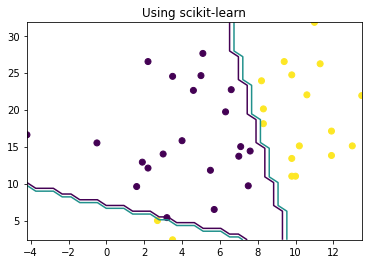

Model accuracity: 0.7692307692307693


In [21]:
xg = np.linspace(x1.min(), x1.max(), len(x1))
yg = np.linspace(x2.min(), x2.max(), len(x2))
xx, yy = np.meshgrid(xg,yg)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
Xcont = poly_features.fit_transform(np.vstack((xx.ravel(),yy.ravel())).T)
Z = logreg.predict(Xcont).reshape(xx.shape)
plt.contour(xx,yy,Z,levels=1)
plt.scatter(x1,x2,c=Yp)
plt.title("Using scikit-learn")
plt.show()
print("Model accuracity:",accuracy_score(cat1,Yp))

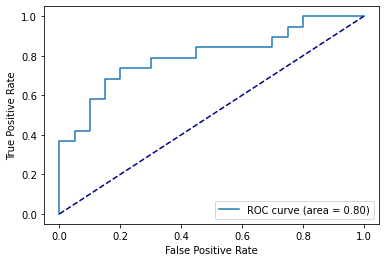

In [22]:
Yprob = logreg.predict_proba(X_poly)
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(cat1, Yprob[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# SVM

In [23]:
def plot_svm_decision_margin(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   s=200, linewidth=1, edgecolors='black', facecolors='none');
    plt.show()

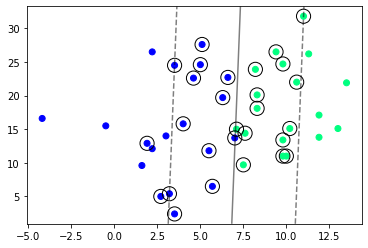

Soft Margin Model accuracity: 0.6923076923076923


In [24]:
model_soft = SVC(kernel='linear')
model_soft.fit(x3, cat1)
Yp_soft = model_soft.predict(x3)
plt.scatter(x1, x2, c=Yp_soft, cmap='winter')
plot_svm_decision_margin(model_soft)
print("Soft Margin Model accuracity:",accuracy_score(cat1,Yp_soft))

# Random forest

In [26]:
from sklearn import tree

def build_forest(X, y, n_trees, max_depth=None):
    forest = []
    for i in range(n_trees):
        model = tree.ExtraTreeClassifier(max_depth=max_depth)
        model.fit(X,y)
        forest.append(model)
    return forest

def rf_predict(forest, X):
    Yps = []
    for m in forest:
        Yps.append(m.predict(X))
    Yps = np.array(Yps).T
    Yp = []
    for i in range(len(X)):
        val, counts = np.unique(Yps[i], return_counts=True)
        j = np.argmax(counts)
        Yp.append(val[j])
    return np.array(Yp).reshape(len(X),1)

forest = build_forest(x3, cat1, 50, 12)

def plot_decision_rf(X, Y, forest, title):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = rf_predict(forest, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:,0],X[:,1],c=Y)
    plt.title(title)

def plot_decision_sl(X, Y, tree, title):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:,0],X[:,1],c=Y)
    plt.title(title)

In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=12)
model.fit(x3, cat1)

RandomForestClassifier(max_depth=12, n_estimators=50, random_state=0)

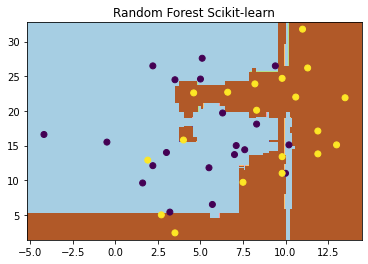

In [28]:
plot_decision_sl(x3, cat1, model, "Random Forest Scikit-learn")

In [29]:
Yp = model.predict(x3)
print("Model accuracity (random forest scikit-learn):",accuracy_score(cat1,Yp))

Model accuracity (random forest scikit-learn): 0.9743589743589743
